In [938]:
from models import NW   
from loaders import load_breast_cancer
import torch
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

In [939]:
import torch.nn as nn
import torch.nn.functional as F

# A relu network with a single hidden layer, with a 1-dimensional input and output
class SimpleNet(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

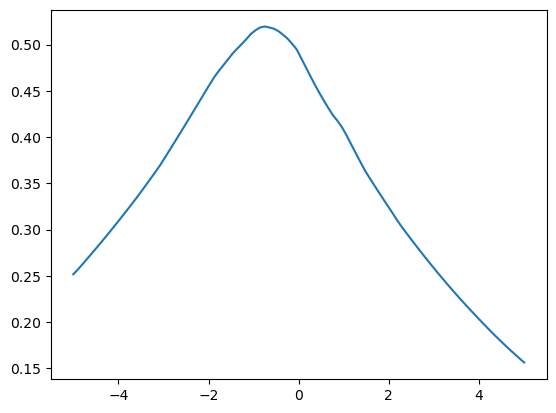

In [940]:
model = SimpleNet(hidden_dim=50)

# Create 100 points in the interval [-5, 5]
X = torch.linspace(-5, 5, 100).reshape(-1, 1)
y = torch.sigmoid(model(X))

# plot X vs y
plt.plot(X, y.detach().numpy())

In [941]:
# A dense layer
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim, activation=torch.tanh):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        return self.activation(x)

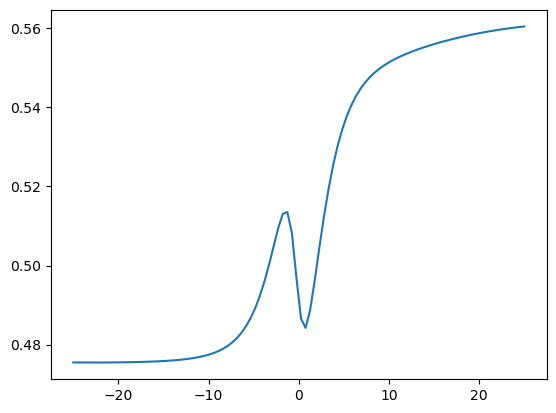

In [942]:
#torch.manual_seed(133742)
# model = SimpleNet(hidden_dim=5)
model = nn.Sequential(Dense(1,10), Dense(10,5), Dense(5,1), nn.Sigmoid())
# print(model)

# plot model(x) for x in [-5, 5]
x = torch.linspace(-25, 25, 100).view(-1, 1)
y = model(x)
plt.plot(x, y.detach().numpy())

In [943]:
X_train, y_train, X_test, y_test = load_breast_cancer()

# Make X data float
X_train = X_train.float()
X_test = X_test.float()

y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

# select radius_mean
# X_train = X_train[:, 0].view(-1, 1).float()
# X_test = X_test[:, 0].view(-1, 1).float()

<AxesSubplot: >

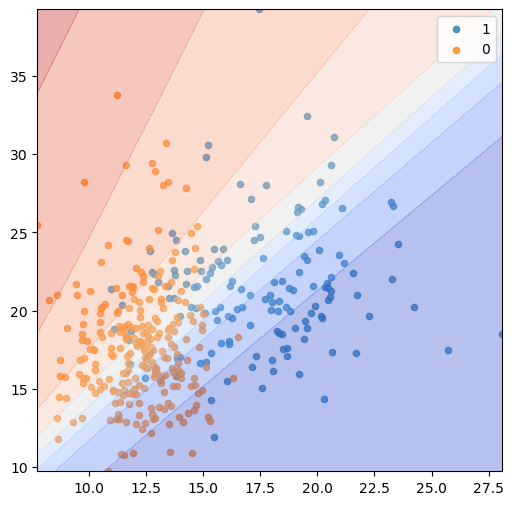

In [944]:
from helpers import train, plot_decision_bounary

# model = nn.Sequential(SimpleNet(input_dim=2, hidden_dim=10), nn.Sigmoid())
model = nn.Sequential(Dense(2,10),  Dense(10,1), nn.Sigmoid())
plot_decision_bounary(model, X_train, y_train)

0.3910209536552429

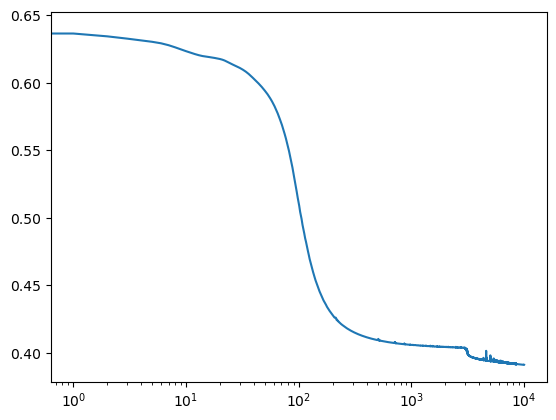

In [945]:
from helpers import gd_with_momentum2

# torch.manual_seed(133)
# torch.manual_seed(42)
torch.manual_seed(8493)

# model = SimpleNet(input_dim=2, hidden_dim=10)
# model = nn.Linear(2, 1)
# Set the weights to 0
# model.weight.data.fill_(0)
# model.bias.data.fill_(0)

model = nn.Sequential(Dense(2,10),  Dense(10,1))
# model = nn.Sequential(Dense(2,10),  Dense(10,10), Dense(10,1))
# model = nn.Sequential(Dense(2,10, torch.relu),  Dense(10, 1, torch.relu))

list(model.parameters())

def log_loss(model):
     # z = model(X_train).view(-1)
     
     # Sample X_train and y_train
     # idx = torch.randint(0, X_train.shape[0], (50,))
     # X_train_sample = X_train[idx]
     # y_train_sample = y_train[idx]
     # X_train_sample = X_train
     # y_train_sample = y_train

     z = model(X_train) 
     return torch.mean(-y_train * z + torch.log(1 + torch.exp(z)))

# loss_hist = gd_with_momentum2(model, log_loss, momentum=0.9, lr=0.04, n_steps=10000)
# loss_hist = train(model, log_loss, n_steps=20000, lr=5e-3, momentum=0.8)

loss_hist = train(model, log_loss, n_steps=10000, lr=1e-2, optimizer=torch.optim.Adam)

# # loss_hist = train(model, F.binary_cross_entropy_with_logits, 1000, lr=0.01)

plt.plot(loss_hist)
# log axis
plt.xscale('log')
loss_hist[-1]

<AxesSubplot: >

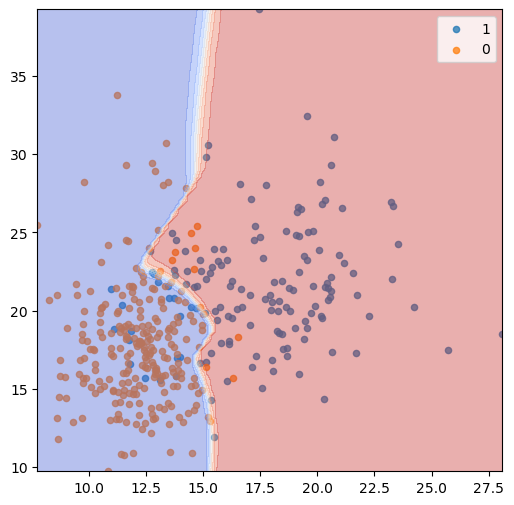

In [946]:
@torch.no_grad()
def wrapped_model(X):
    return torch.sigmoid(model(X))

plot_decision_bounary(wrapped_model, X_train, y_train)

In [947]:
# accuracy on the test set
with torch.no_grad():
    y_pred = wrapped_model(X_test)
    y_pred = (y_pred > 0.5).float()
    print((y_pred == y_test).float().mean())

tensor(0.8713)


In [948]:
# print model parameters named
for name, param in model.named_parameters():
    print(name, param)


0.fc.weight Parameter containing:
tensor([[ 0.4419,  0.1922],
        [ 0.4517,  0.0593],
        [-4.3632,  2.4084],
        [-0.5216, -0.5573],
        [-0.6826, -0.4337],
        [-3.0912,  2.6418],
        [ 0.2623,  0.5804],
        [ 0.0158,  0.2000],
        [-0.4625,  0.0376],
        [ 0.4689,  0.4063]], requires_grad=True)
0.fc.bias Parameter containing:
tensor([ 0.4042,  0.4960, -2.9259,  0.3230,  0.2445, -0.8209,  0.0901, -4.1242,
         6.6095, -0.1989], requires_grad=True)
1.fc.weight Parameter containing:
tensor([[  0.7402,   0.5721,  -5.4250,  -0.4725,  -0.6300,  -5.7007,   0.7581,
          18.3197, -15.5093,   0.7297]], requires_grad=True)
1.fc.bias Parameter containing:
tensor([0.9343], requires_grad=True)
